# Classification using pretrained, well-known models
This notebook aims to create a set of benchmarks for the project, using well-known, thoroughly studied models.
Either with pretrained weights, or training with new data.

## Notes
### 21.08.19
Attempting to classify with VGG has not proven effective yet.
Initially, the image data was note scaled at all. Implemented scaling in the
import function, using min-max scaling of the value. This preserves the inherent
intensity difference between images.

The number of layers of VGG16 used is varied between 3 to 9 without noticable
difference. Attempting to find out why, by analyzing the extracted features.
The idea is that in order to classify, the feature distribution should be
different for images containing single and double events.
I first attempt this with manual qualitative inspection.

Manual, qualitative inspection reveals that the distributions look very similar.
Performing a quantitative study using Kolmogorov-Smirnov two-sample test,
comparing the distribution for each feature.

* For 1 block (depth 3), the pvalue returned from comparisons is 1.0 for all features.
* For 2 blocks (depth 6), the pvalue returned from comparisons is 1.0 for all features.
* For 3 blocks (depth 10), the pvalue returned from comparisons is 1.0 for all features.
* For 4 blocks, (depth 14) the pvalue returned from comparisons is 1.0 for all features.
* For 5 blocks, (depth 18) the pvalue returned from comparisons is 1.0 for all features.

This indicates that extracting features using vgg16 doesn't work for classification.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
import master_data_functions.functions as dfunc

# silence deprecation warnings from tensorflow
import warnings
warnings.simplefilter('ignore', FutureWarning)

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples

keywords = {
    "single_1": "CeBr10kSingle_1",
    "single_2": "CeBr10kSingle_2",
    "mix": "CeBr10k_1",
    "small": "CeBr10"}
    
dataset = "mix"
data = dfunc.import_data("sample")
images = data[keywords[dataset]]["images"]
energies = data[keywords[dataset]]["energies"]
positions = data[keywords[dataset]]["positions"]
labels = to_categorical(data[keywords[dataset]]["labels"])
n_classes = labels.shape[1]


print("Number of classes: {}".format(n_classes))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))
      

/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

Number of classes: 2
Energies shape: (10000, 2)
Positions shape: (10000, 4)
Labels shape: (10000, 2)


In [2]:
# VGG16 expects 3 channels. Solving this by concatenating the image data 
# to itself, to form three identical channels

images = np.concatenate((images, images, images), axis=3)

print("Image data shape: {}".format(images.shape))

Image data shape: (10000, 16, 16, 3)


## VGG-16 feature extraction


In [45]:
from master_models.pretrained import vgg_model
vgg = vgg_model(output_depth=18)
vgg.summary()



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block3_conv1 (Conv2D)        multiple                

In [47]:
# Extract features with vgg
vgg_features = vgg.predict(images)

In [48]:
# Check distribution of features

manual_inspect = False

single_features = vgg_features[np.where(labels[:,0] == 1)]
double_features = vgg_features[np.where(labels[:,1] == 1)]

if manual_inspect:
    index = 9 
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
    for i in range(3):
        for j in range(3):
            # plot features
            ax[i, j].hist(single_features[:,index + i*3 + j], alpha=0.5, label='single')
            ax[i, j].hist(double_features[:,index + i*3 + j], alpha=0.5, label='double')
            ax[i, j].legend()
    plt.show()

In [49]:
from scipy.stats import ks_2samp
from tqdm import tqdm
from joblib import Parallel, delayed
# Check difference using Kolmogorov-Smirnov

def get_pval(i):
    ks = ks_2samp(single_features[:,i], double_features[:,i])
    return ks.pvalue

n = vgg_features.shape[1]
p_values = Parallel(n_jobs=-1, verbose=2)(delayed(get_pval)(i) for i in range(n))




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    8.8s finished


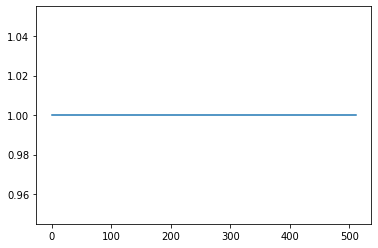

In [50]:
plt.plot(range(len(p_values)), p_values)
plt.show()

## Classification with custom dense network
### Build dense model

In [ ]:
# Train a fully-connected network to classify based on
# extracted features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(4096, input_shape=vgg_features.shape[1:]))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

### Set up training and test data

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(vgg_features, labels, test_size = 0.2)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

In [ ]:
# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=128,
    validation_data=(x_test, y_test))

In [ ]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Check predictions
predicted = model.predict(x_test)
print(len(predicted[np.where(predicted[:,1] == 1.0)]))